# Assignment 08

**Due:** 2022-05-03 (Tue), 11:59 PM, as a Jupyter notebook (with related files) submitted via your repo in the course GitHub organization.  Use the solutions template notebook, and **be sure not to modify the subproblem cells** in your solution file.  This assignment is **mandatory**.

***Note that Problem 2 is for 5780 students only.***

### Collaboration disclosure

(See the [`CourseInfo`](https://github.com/CU-BDA-2022/CourseInfo) repo's `README` file for a description of what's expected here. You may leave this cell unmodified if you worked entirely alone on this assignment. Collaboration is encouraged, following the guidelines in the `README`.)

**Note regarding Problem 1:** Doing all of the calculations for problem 1 entirely in your `Solutions08` Jupyter notebook will make the notebook unwieldy (both to work on, and to grade).  In addition, you may find it easier to debug parts of your work in a script rather than in a notebook. 

Accordingly, aim to *execute just a single Stan fit in your solution notebook* for this assignment.  Other work can be done in a script or separate notebook, with figures saved as PNG files via matplotlib's `savefig` command, and placed in your `Solutions08` notebook in a Markdown cell. You can use standard Markdown markup for inserting images, e.g., `![Description](imag-file-name.png)`. Alternatively, you can use an HTML tag, which lets you control the image size in the notebook (see Markdown cells below for examples).

Your solution will rely on MCMC calculations, and of course you'll need to compute some output diagnostics to assure yourself that you are getting reliable results and a large enough effective sample size. Those calculations should be done in your external script or notebook, and only briefly summarized in the `Solutions08` notebook, as requested below.

Indicate the name (or names) of any extra scripts or notebooks you used for results placed in the `Solutions08` notebook in the next Markdown cell.

**Make sure you commit, not just your notebook, but also all of the Python modules, scripts, extra notebooks, and images needed to run the notebook and to produce the content included in it.**

**Do not commit your cached Stan model files.** Those are platform-dependent. The course's `.gitignore` file (which you should have put in your repo long ago) should tell Git to ignore the cached model files by default.

## Accompanying scripts and/or notebooks:

myscript.py **<-- EDIT identifying any accompanying scripts**

In [58]:
# The usual imports:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from numpy import *
from scipy import stats

## 1. Linear regression and global warming

### Note:  This exercise does not comprise a serious scientific analysis of global warming data!

This exercise is meant to give you some experience with both linear regression and Stan, and to help you gain some insight into issues, both subtle and not-so-subtle, that arise in trying to predict the behavior of a complex system using *phenomenological models* (i.e., not physical or first-principles models; see [Phenomenological model - Wikipedia](https://en.wikipedia.org/wiki/Phenomenological_model)).

A Python module, implemented in `climate_helpers.py`, accompanies this assignment; it includes both code and data you'll use for your solutions.  Also, the StanFitter module, `stanfitter.py`, which you've encountered earlier, accompanies this assignment.

In [59]:
from climate_helpers import giss_temp_data, years, dTs, MonomialBasis, ChebyshevBasis
from stanfitter import StanFitter

The `climate_helpers` module provides time series data from NASA's Goddard Institute for Space Science (GISS). GISS scientists carefully compute the *Global Annual Mean Surface Air Temperature Change* (reported as a *temperature anomaly*, i.e., a temperature change from a fiducial period, in degrees C) based on a wide array of input data, available back to 1880.  The data are hosted [at GISS](https://data.giss.nasa.gov/gistemp/); NASA hosts several web sites discussing this and other data pertinent to climate change, including [sites directed to a nontechnical audience](http://climate.nasa.gov/vital-signs/global-temperature/).

Computing global temperatures and temperature changes is a tricky business.  If you'd like to learn more about it, check out these resources:
* [Pubs.GISS: Hansen et al. 2010: Global surface temperature change](https://pubs.giss.nasa.gov/abs/ha00510u.html) — This describes the methodology used to produce the GISS data.
* [Pubs.GISS: Lenssen et al. 2019: Improvements in the GISTEMP uncertainty model](https://pubs.giss.nasa.gov/abs/le05800h.html) — This describes an update on how temperature anomaly uncertainties are computed for plots shown at the GISS web site.
* [Climate Resource Center - Earth's temperature record](https://climate.nasa.gov/climate_resources/9/graphic-earths-temperature-record/)
* [Why so many global temperature records?](https://climate.nasa.gov/news/2241/why-so-many-global-temperature-records/)
* ["Berkeley Earth: raw versus adjusted temperature data " (Climate Etc. blog)](http://judithcurry.com/2015/02/09/berkeley-earth-raw-versus-adjusted-temperature-data/)

Here's what the GISS time series looks like:

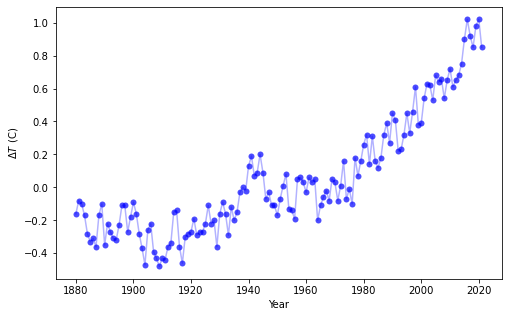

In [3]:
temp_fig = figure(figsize=(8,5))
temp_ax = axes()
plot(years, dTs, 'b-', alpha=.3)
# plot(years, dTs, ls='None', marker='o', ms=8, mfc='b', mew=0, alpha=.7)
plot(years, dTs, ls='None', marker='o', ms=6, mfc='b', mew=0, alpha=.7)
xlabel('Year')
ylabel(r'$\Delta T$ (C)');

You are hopefully familiar with the "hockey stick diagram" that shows how anomalous the recent warming trend is in the context of thousands of years of past climate change, with temperatures inferred from various proxies. For context, the following figure shows a much longer history of global mean temperarture change, from a recent analysis of 24,000 years of climate data (using Bayesian methods); the part of the curve spanning the last ~10,000 years displays the "hockey stick" shape:

![Global mean surface temperature change over the past 24 kyr](O+21-GlobalTempChange.png)

Note the change in the scale of the time axis for the last 1000 years. This figure is from the following paper published in *Nature* in November 2021: [Globally resolved surface temperatures since the Last Glacial Maximum](https://www.nature.com/articles/s41586-021-03984-4). An *Ars Technica* news article summarizing this work is here: [Scientists extend and straighten iconic climate “hockey stick”](https://arstechnica.com/science/2021/11/scientists-extend-and-straighten-iconic-climate-hockey-stick/).

The GISS data corresponds to the uptick part of the hockey stick—the time period where we have accurate direct measurements of temperatures across the globe.

In this exercise, we'll explore fitting the data, and predicting the future temperature anomaly to 2050, based on linear regression in a polynomial basis, with a normal conditional distribution for the temperature anomaly at a given time (reflecting a combination of natural variation and measurement error; we'll determine the width of the conditional distribution from the data).

We'll consider _**two different polynomial bases**_, covering times out to 2050:

In [4]:
# Extended array of years, including prediction interval:
xyears = arange(years[0], 2051.)


The module provides two classes for building polynomials and evaluating them on an array of times to build the set of basis functions for regression (aka, the design matrix).  One uses the familiar **monomials** (1, $x$, $x^2$, $x^3$, $\ldots$).  The other uses **Chebyshev polynomials**, an *orthogonal basis* (see [Chebyshev Polynomial of the First Kind at MathWorld](https://mathworld.wolfram.com/ChebyshevPolynomialoftheFirstKind.html) and [Chebyshev polynomials at Wikipedia](http://en.wikipedia.org/wiki/Chebyshev_polynomials); the first few basis functions are 1, $x$, $2x^2-1$, $4x^3 - 3x$).  The classes that define them for you also let you define **independent normal priors over the polynomial coefficients**, so we can study how the choice of basis and priors may potentially influence inferences.

Take a look at the code so you have a basic grasp of how the bases are computed (you won't be modifying the code, so you needn't understand it in detail).  Note that, internally, the classes map the years to a variable $x \in [-1,1]$, to help make the basis functions numerically well-behaved and of similar scale to each other.

In [55]:
# 5th-degree bases with zero-mean priors, sig=2:
deg = 5  # number of terms = deg + 1
mono = MonomialBasis(deg, xyears, sigma=2.)
cheb = ChebyshevBasis(deg, xyears, sigma=2.)

After creating a basis instance, the **`basis`** attribute (e.g., `mono.basis`) is a 2-D array `basis[i,j]` that gives the value of basis function `j` at time `i`; this is the transpose of the $g_{\alpha i}$ matrix from the lectures on regression, i.e., it is the design matrix.

There are two methods that you'll use.  For a 1-D array of coefficients, `beta`, the method call **`func(beta)`** evaluates the polynomial defined by `beta` over all the times (years), returning a 1-D array of values $f_i$, with
$$
f_i = \sum_j \beta_j g_j(t_i),
$$
where $g_j(t)$ is basis function $j$.

The method call **`sample()`** returns a polynomial sampled from the prior, as a 1-D array of values at all the times.  That is, it samples $\beta_j$ values from the priors, and then evaluates the polynomial with those coefficients.  As a (deliberately vague!) example, one choice of basis and degree produces this set of 50 prior samples:

<img width=650 src="climate-PolyPriorSamplesEx.png">

In [227]:
shape(mono.func([1,1,1,1,1]))

(171,)

### Problem 1.1 (1 point):

> * Make a 2-panel plot (use `figure(figsize=(...))` and `subplot(...)` with appropriate arguments), showing 50 samples from each of the two degree 5 bases just defined.  Be sure to title the subplots, identifying the cases.  If done correctly, the two plots should look quite different.
> * From the perspective of an investigator wanting to be noncommital about global temperature trends a priori (i.e., allowing the greatest variety of possible shapes a priori), which basis/prior combination appears to be the better one to you?  Briefly explain why.

Text(0.5, 1.0, 'Chebyshev polynomials sample prior')

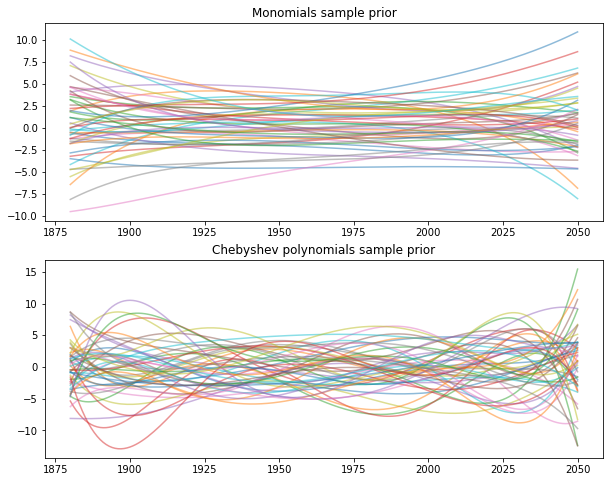

In [217]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)
fig, (ax1, ax2) = plt.subplots(2)
for i in range(50):
    ax1.plot(xyears,mono.sample(), '-',alpha=.5)
    ax2.plot(xyears,cheb.sample(), '-',alpha=.5)
ax1.set_title('Monomials sample prior')
ax2.set_title('Chebyshev polynomials sample prior')

Chebyshev polynomials sample prior seems to be better. It is hard to find a consistent pattern for this type of prior and it satisfies the investigator's requirement to allow the greatest variety. Samples from the monomials priors all have a similar pattern.

For a problem where there aren't clear principles defining a unique prior, a good Bayesian analysis will be concerned with *robustness of conclusions with respect to priors*.  The investigator should examine how much the findings are affected by reasonable changes in priors.

Here, one way you'll get a handle on robustness to priors is to try **fits with both bases**.  Even if you use priors of the same form for the coefficients in both bases, these priors express quite different prior distributions over the space of polynomials. (That is, even though we are using the name `beta` or the symbols $\beta_\alpha$ for the coefficients in each basis, the coefficients mean something different for each basis, so assigning the *same* prior PDFs over them corresponds to *different* priors over the space of polynomials. We could make this extra clear by giving different names to the coefficients in each case, but that would make the code unwieldy.)

Importantly, you will also explore robustness of inferences with respect to the **degree** of the basis.  The degree is essentially a discrete parameter.  A more complete analysis than you'll pursue here would try to *quantify* uncertainty in the polynomial degree (e.g., via Bayes factors or out-of-sample predictive criteria).  You'll explore the consequences of polynomial degree uncertainty in this problem only qualitatively here.

You now have data and basis functions for linear models; next do some fits.

### Problem 1.2 (1 point):

> * Below you'll find incomplete Stan code for a linear regression model for the global warming data.  The `model` section is empty.  Complete it, consulting the [Stan Modeling Language User's Guide](http://mc-stan.org/users/documentation/index.html) for how to build regression models in Stan (see Section 1.1, on linear regression; note that the basis functions include the "intercept" term discussed at the end of that section).  The model code should have three main ingredients:
    * Priors for the coefficients (set in a loop over the coefficients in the `beta` vector); use zero-mean normal priors with standard deviation $= 2$, as used for your prior sample plots.
    * A prior for $\sigma$, the conditional standard deviation for the temperature measurements.  Adopt an exponential prior with a mean of 2., a broad prior compared to the visual scale of the temperature fluctuations over short time spans.
    * A sampling distribution (defining the likelihood function) for the temperature change data vector.  Do this using Stan's implicit looping capability (i.e., write it without using a `for` loop; this is discussed in that same section).
> * Compile the model with StanFitter.

Note that since the basis gets passed in as "data" (including the number of coefficients) *you only need a single fitter instance* to fit multiple models with different bases and degrees.  You'll only have to alter the code and recompile it if you change the priors (other than changing the bases).

In [50]:
# Stan code for linear regression:
#in vector notation
lin_regn_code = """
data {
    int<lower=0> n; // number of times sampled
    int<lower=0> m; // number of coeff = deg + 1
    matrix[n,m] basis; // basis funcs, aka design matrix #in helper compute
    vector[n] dT; // temp change
}

parameters {
    vector[m] beta;  // coeficients
    real<lower=0> sigma;  // noise scale
}

model {
    // FILL IN HERE; SEE STAN MANUAL
    beta ~ normal(0, 2.); // prior is a wide normal
    sigma ~ exponential(2.);
    dT ~ normal(basis*beta,sigma);

}
"""

# Uncomment to compile finished code:
fitter = StanFitter(lin_regn_code, name='lin_regn')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ee2acf2b3f481343f5735517ddea234 NOW.
clang-11: warning: -Wl,-export_dynamic: 'linker' input unused [-Wunused-command-line-argument]
In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:777:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecate

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:787:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned long long, 25214903917, 11,

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

In file included from /var/folders/fh/krs90p1n6zndt35tf_n8m5sw0000gn/T/pystan_4255ax69/stanfit4anon_model_7ee2acf2b3f481343f5735517ddea234_2226709916144490854.cpp:786:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/py37stan2/lib/python3.7

155 warnings generated.
ld: warning: -pie being ignored. It is only used when linking a main executable


You'll use the `fitter` instance as we did in previous exercises, but you'll use some new capabilities.

`fitter.mode()`

runs Stan's default optimizer, returning the posterior mode as an object with both a dict and an attribute interface to the parameter values and the log density.  That is, if you write

    mode = fitter.mode()

then `mode.sigma` and `mode['sigma']` are both ways to access the value of $\sigma$ at the mode, and `mode.beta` and `mode['beta']` are *arrays* with the values of the coefficients at the mode. Likewise, `mode.log_p` and `mode['log_p']` give the log of the posterior density at the mode.

_**IMPORTANT NOTE:**_ `Stan` treats arrays as 1-based (the first element of `beta` is accessed using `beta[1]`), while Python treats arrays as 0-based (the first element is accessed using `beta[0]`).

The `StanFitResults` instance returned by

    fit = fitter.sample(...)

has useful attributes you may not have explored yet.  After sampling, the fitter finds the smallest ESS among the parameter Markov chains, and uses it to provide an array of samples for each parameter constructed by thinning the chains and concatenating them, for each parameter. You may find the following attributes and methods useful for working with the thinned chains.
* `fit.min_ess` tells you the smallest ESS among the parameter Markov chains.
* `fit.thinned_by` tells you by how much each chain was thinned.
* `fit.sigma.thinned`, `fit.beta[0].thinned`, etc., give you access to the thinned, merged chain for each parameter (including `log_p`).
* `fit.subsample_indices(n)` returns a list of `n` randomly chosen indices into the thinned, merged chains, which you can use to pull out a subset of posterior samples chosen fairly across the merged chains.
* `fit.point(t)` returns all of the parameter values at time `t` in the set of thinned chains.  It's the same kind of object as is returned by `fitter.mode()`.

You'll use these capabilities to produce plots resembling this one:

<img width=650 src="climate-PolyFitEx.png">

In [67]:
#grey:std
#draw a bunch of cooefficient and draw the line
#compare the two prior and 4/5th polynomial
#prior affects the result?
#how the degree affect the data

### Problem 1.3 (2 points):

> * Write a function, `fit_model`, building on the stub provided below, that does the following, producing a single plot:
> * Build a basis of specified type and degree.
>  * Fit the data, obtaining the posterior mode and posterior samples.
>  * Plot the data.
>  * Plot 40 polynomials sampled from the posterior, as thin curves with colors automatically chose by matplotlib.  Use a small `alpha` opacity (say, .2), so curves remain visible despite overlap.
>  * Plot a thick dashed curve showing the polynomial corresponding to the mode.
>  * Plot a single error bar somewhere along the curve displaying the value of $\sigma$ at the mode.
>  * Return the (MCMC) fit results and mode.

Your work for this subproblem should all be in the next single cell; you'll *use* the function below.

In [260]:
def fit_model(fitter, Poly, deg, csig, n_iter=1000, n_chains=4,
              years=years, dTs=dTs, xyears=xyears):
    """
    Fit the data and summarize results.

    Parameters
    ----------
    
    fitter : StanFitter instance
    
    Poly : Polynomial basis class
    
    deg : int
        Degree of polynomial to fit

    csig : float
        Coeffient prior standard deviation

    n_iter, n_chains : int
        The number of iterations per chain, and number of chains, for Stan fits

    years, dTs, xyears : float arrays
        Data (years, dTs) and extended years covering data and prediction
        interval (xyears)
    """
    nbeta = deg + 1  # number of coefs
    # Build a basis over the fit+prediction interval.
    poly = Poly(deg, xyears, sigma=csig)
    # For fitting the data, pull out the part spanning years.
    data_basis = poly.basis[:len(years),:]
    # Data dict for Stan:
    data = dict(n=len(years), m=nbeta, basis=data_basis, dT=dTs)

    # Do the fit, MCMC and optimization:
    fitter.set_data(data)
    fit = fitter.sample(n_iter, n_chains)
    mode = fitter.mode()

    # Plot dTs:
    temp_fig = figure()
    temp_ax = axes()
    plot(years, dTs, 'b-', alpha=.3)
    plot(years, dTs, ls='None', marker='o', ms=6, mfc='b', mew=0, alpha=.7)
    xlabel('Year')
    ylabel(r'$\Delta T$ (C)')
    xlim(xyears[0], xyears[-1])
    ylim(-1.5, 1.5)
    
    #plot 40 polynomial samples)
    ind=fit.subsample_indices(40)
    data_basis_n = poly.basis[:len(xyears),:]

    for i in range(40):
        ch=int(ind[i]/500)
        mu=fit.chains[ind[i]-ch*500,ch,0:5]
        #print(mu)
        sig=fit.chains[ind[i]-ch*500,ch,5]
        mm=Poly(deg, xyears,sigma=sig)
        plot(xyears,mm.func(mu), '-',alpha=.4)  

    #Plot a thick dashed curve showing the polynomial corresponding to the mode.
    mmm=Poly(deg, xyears,sigma=mode.sigma)
    plot(xyears,mmm.func(mode.beta), '--',alpha=1,color='black',linewidth=6)
    
    #Plot a single error bar somewhere along the curve displaying the value of σ at the mode.
    errorbar(xyears[20],mmm.func(mode.beta)[20], yerr=mode.sigma,elinewidth=4,capsize=10)
    return fit, mode
    

### Problem 1.4 (2 points):

> * Use `fit_model` to use both the monomial and Cheybshev bases to fit **4th degree** polynomials to the data, with the coefficient priors having standard deviation `csig=2.0`.  The notebook should execute one of the `fit_model` calls, but you should execute the other in a script, just including the plot in the notebook.  Use the returned `fit` objects to assure yourself of convergence and good mixing.  You need not provide plots and printouts in the notebook for this, but you should include a Markdown cell below with a *brief* description of what you did regarding output diagnostics.
> * Briefly comment on what the two fits tell you about sensitivity of the results to the prior over polynomials.


Gradient evaluation took 0.000101 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.000119 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.19 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)

Gradient evaluation took 0.002789 seconds
1000 transitions using 10 leapfrog steps per transition would take 27.89 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000149 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.49 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 18)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 18)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the 

Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.177843 seconds (Warm-up)
               0.171667 seconds (Sampling)
               0.34951 seconds (Total)

Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.181582 seconds (Warm-up)
           

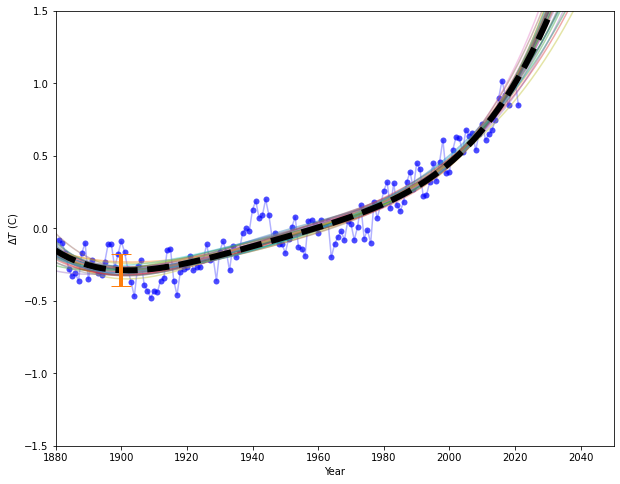

In [262]:
fit,mode=fit_model(fitter, MonomialBasis, deg=4, csig=2., n_iter=1000, n_chains=4,years=years, dTs=dTs, xyears=xyears)

<img width=500 src="chev.png">

The output of both fit shows that

### Problem 1.5 (2 points):

> * Use `fit_model` to use both monomial and Cheybshev bases to fit **5th degree** polynomials to the data, with a prior standard deviation `csig=2.`.  Show the plots you produce in the notebook, clearly identified (the code should be in a separate script).
> * In words, compare the 4th degree and 5th degree results, and briefly comment on the implications of the difference for using phenomenological vs. physical models to make predictions from climate data.

## 2. Inference with uniformly distributed data (for 5780 students only)

Some familiar frequentist approaches (such as maximum likelihood estimation) have trouble in problems where a parameter determines the **support** of the sampling distribution (the region in sample space over which it is nonzero).  Such problems don't require any change of principles in Bayesian inference (although in complex settings they may require special computational considerations). Here you'll consider problems involving the **uniform distribution**, with either an unknown width, or an unknown location.

*Broader context:* As an aside, these problems can be viewed as very simple examples of *change point problems*—estimating where or when the probability distribution (or Poisson intensity) for observed events may have abruptly changed. For more on Bayesian approaches to such problems, see the following references:
* [Parametric Statistical Change Point Analysis | SpringerLink](https://link.springer.com/book/10.1007/978-0-8176-4801-5), a 2012 book reviewing change point methods, with sections devoted to Bayesian methods in several chapters;
* [[1908.07136] A Review of Changepoint Detection Models](https://arxiv.org/abs/1908.07136), a brief review of change point detection methods, with a section devoted to Bayesian methods up to about 10 years ago;
* [Bayesian Hierarchical Model for Change Point Detection in Multivariate Sequences: Technometrics: Vol 64, No 2](https://www.tandfonline.com/doi/abs/10.1080/00401706.2021.1927848), a recent research paper which provides pointers to Bayesian change point work in section 2;
* [[2201.06606] Decoupling Trends and Changepoint Analysis](https://arxiv.org/abs/2201.06606), a preprint describing recent PhD work on Bayesian change point modeling done by David Matteson's group here at Cornell.

### Problem 2.1 (2 points):

Demonstrate inference of the width of a fixed-location uniform distribution, with width $\Delta$ and location $m=0$ on the $x$ axis, with $m$ denoting its known midpoint, and $\Delta$ unknown.

> * Write down the likelihood function for $\Delta$ given the locations $\{x_i\}$ of $N$ samples.
> * Adopt a log-flat (i.e., scale-invariant) prior for $\Delta$, i.e., $\pi(\Delta)\propto 1/\Delta$, and compute the posterior for $\Delta$ (analytically!).
> * How many samples are required for the posterior to be proper?  (*Comment:* This bears on the appropriateness of the prior as an expression of ignorance of the width. That is, if there is a minimum sample size for which it makes sense to estimate a parameter, a reasonable requirement for an "uniformative" prior is that it give a proper posterior only when that minnimum sample size is attained.)
> * Find a closed-form expression for the posterior mean for $\Delta$.

### Problem 2.2 (2 points):

Suppose you have a digital clock that displays the time to the minute, which runs at an accurate rate but which is not set to perfectly match [official US time](http://www.time.gov/).  After hearing (official) time announcements on the radio over the course of a few days (public radio, of course!), announced with 1-minute precision, you realize your clock is set slightly late, by an amount $\delta t$ less than 1 minute; that is, you sometimes hear the announced time matching your clock's displayed time, but you sometimes hear it announced earlier.
> Suppose the radio announcers announce the time at moments chosen uniformly at random.  If you hear $N$ total announcements, $n$ of them matching your clock's displayed time, what is the posterior PDF for your clock's time lag, $\delta t$? Choose a prior yourself, but motivate your choice.